# Home Work 5 Случайный лес


Для выполнения домашнего задания будем использовать данные из файла Lesson_5_extended.ipynb (из материалов к уроку).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import numpy as np
%matplotlib inline

In [2]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями.

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [11]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [16]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, train_labels, test_data, test_labels, forest):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    
    plt.show()

### Задача 1.  
#### Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках.

In [17]:
# сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

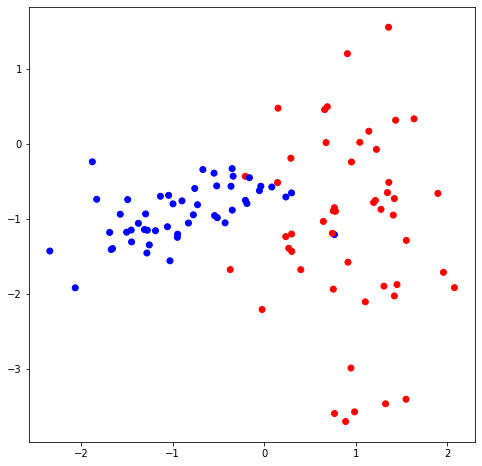

In [18]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=23)


Число деревьев в случайном лесе: 	1
Точность обучающей выборки: 	94.28571428571428
Точность тестовой выборки: 	80.0


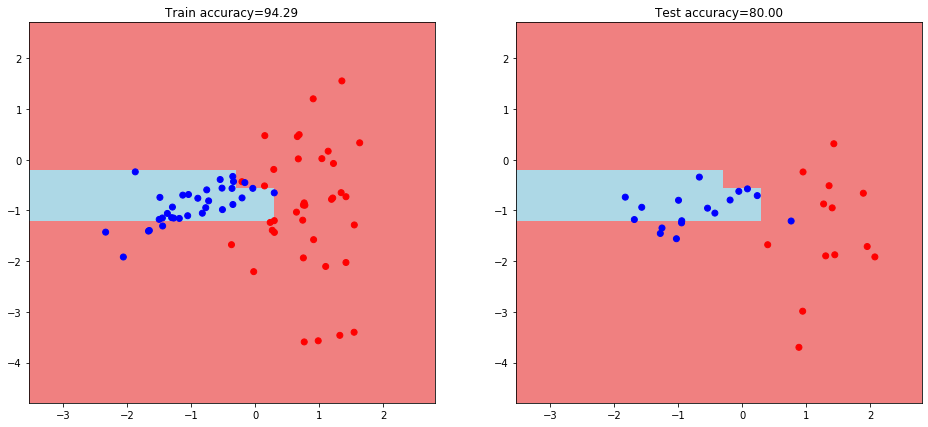


Число деревьев в случайном лесе: 	3
Точность обучающей выборки: 	97.14285714285714
Точность тестовой выборки: 	90.0


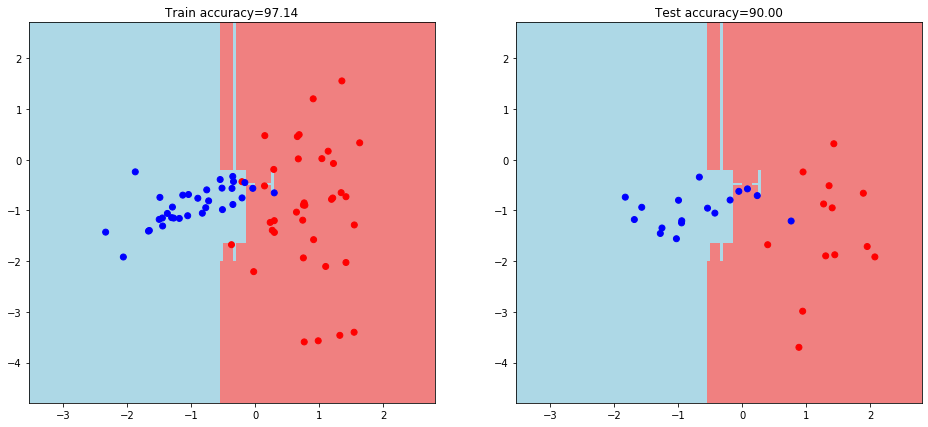


Число деревьев в случайном лесе: 	10
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	90.0


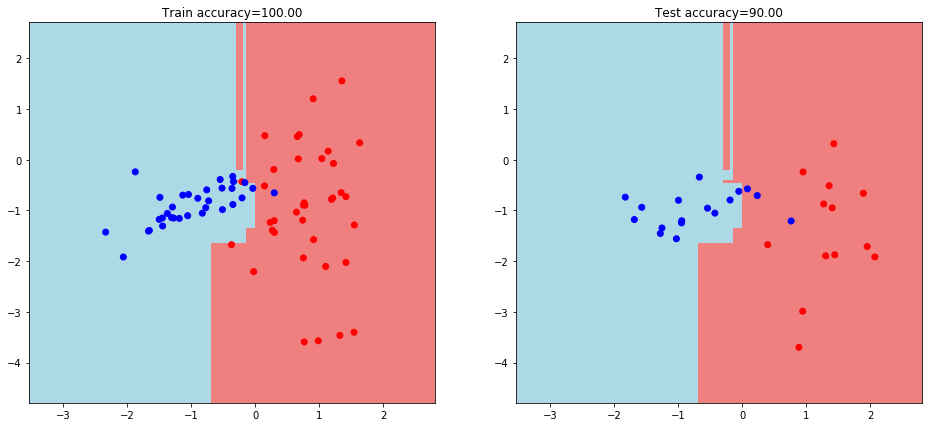


Число деревьев в случайном лесе: 	50
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	90.0


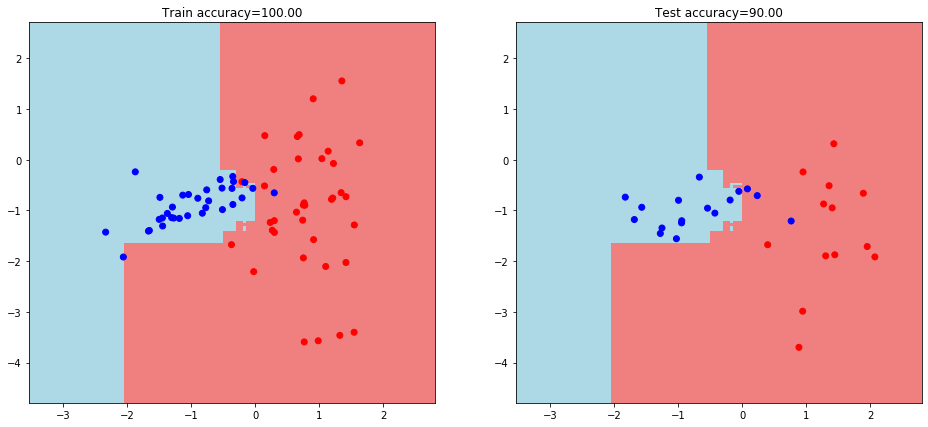

In [20]:
for n_trees in [1, 3, 10, 50]:
    # обучение
    my_forest = random_forest(train_data, train_labels, n_trees)

    # предсказание
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)

    # параметры точности
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    print(f'\nЧисло деревьев в случайном лесе: \t{n_trees}\nТочность обучающей выборки: \t{train_accuracy}\nТочность тестовой выборки: \t{test_accuracy}')

    visualize(train_data, train_labels, test_data, test_labels, my_forest)

### Задача 2.  
**Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**

Лес из 1 дерева выглядит недобученным, гиперплоскость выглядет слишком простой.  
Чем больше число деревьев в случайном лесе, тем выше точность на обучающей выборке и тем сложнее разделяющая гиперплоскость. Но при этом точность на тестовой выборке меняется не сильно.  
Леса с большим количеством деревьев выглядят переобученными, гиперплоскость выглядет сложной, что скорее всего связано с малой выборкой

### Задача 3*  
**Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.**

Переопределим метод получения бутстрап-выборки get_bootstrap таким образом, чтобы он возвращал ещё и отложенную выборку. Учтем это в методе построения случайного леса random_forest. Это метод сразу будет вычислять out_of_bag_score по данным, не входящим в бутстрап-выборки.

In [21]:
# Получение N бутстрап-выборок и N массивов индексов данных, которые входят в соответствующую бутстрап-выборку.

def get_bootstrap(data, labels, N):
    random.seed(10)

    n_samples = data.shape[0]
    bootstrap = []
    b_indexes = []

    for i in range(N):        
        sample_indexes = [random.randint(0, n_samples-1) for _ in range(n_samples)]
        bootstrap.append((data[sample_indexes], labels[sample_indexes]))
        b_indexes.append(sample_indexes)
        
    return bootstrap, b_indexes

In [22]:
# Метрика точности для данных, не входящих в бутстрап-выборки 

def out_of_bag_score(data, labels, b_indexes, forest):
    predictions = []
    actual = []

    # перебираем все имеющиеся данные 
    for i in range(data.shape[0]):

        # индексы деревьев, которые не обучались на текущем наблюдении
        index_tree = [] 
        for idx, b_index in enumerate(b_indexes):
            if i not in b_index: 
                index_tree.append(idx)

        if len(index_tree) != 0:
            new_forest = [forest[k] for k in index_tree] # новый лес на деревьях, которые не обучались на текущем наблюдении
            predictions.append(tree_vote(new_forest, [data[i]])[0]) # предсказание по текущему наблюдению
            actual.append(labels[i]) # истинное значение класса текущего наблюдения

    return accuracy_metric(actual, predictions)

In [23]:
# Формирование случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, b_indexes = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    
    # считаем ошибку по данным, не входящим в бутстрап-выборки 
    oob_score = out_of_bag_score(data, labels, b_indexes, forest)

    return forest, oob_score

In [24]:
n_trees_arr = np.arange(1, 51, 1)
oob_scores = []

for n_trees in n_trees_arr:
    _, oob_score = random_forest(classification_data, classification_labels, n_trees)
    oob_scores.append(oob_score)

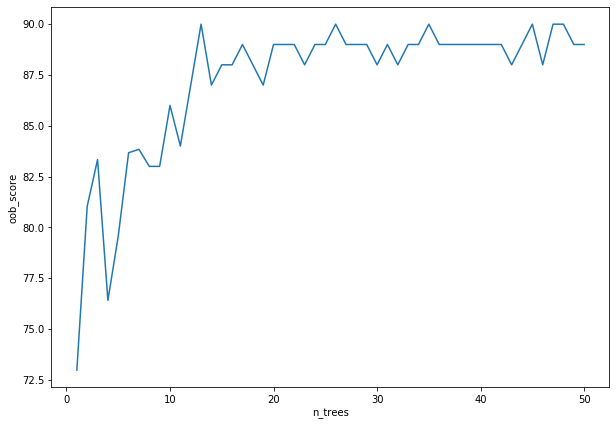

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(n_trees_arr, oob_scores)
plt.xlabel('n_trees')
plt.ylabel('oob_score')
plt.show()

### Задача 4* (На повторение).
**Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.**

Индекс Джини:$$H(X) = \sum_{k=1}^K p_k(1 - p_k)$$

Энтропия Шеннона:$$H(X) = -\sum_{k=1}^K p_k\log_2p_k$$

Дисперсионный критерий:$$H(X) = \frac{1}{X}\sum_{i\in{X}}(y_i - \overline{y}(X))^2$$

Дисперсионный критерий используется в задачах регрессии, критерий Джени и энтропийный критерий Шеннона используются в задачах классификации.

In [26]:
# Расчет энтропийного критерия Шеннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0    
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

Переопределим метод вычисления функционала качества и метод нахождения наилучшего разбиения так, чтобы они использовали энтропийный критерий Шеннона в качестве критерия информативности.

In [27]:
# Расчет качества с использованием энтропии Шеннона

def quality(left_labels, right_labels, current_entropy):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [28]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = entropy(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]

    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

              #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#           if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#               continue

            current_gain = gain(true_labels, false_labels, current_entropy)
                        
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [29]:
oob_scores_2 = []

for n_trees in n_trees_arr:
    _, oob_score = random_forest(classification_data, classification_labels, n_trees)
    oob_scores_2.append(oob_score)

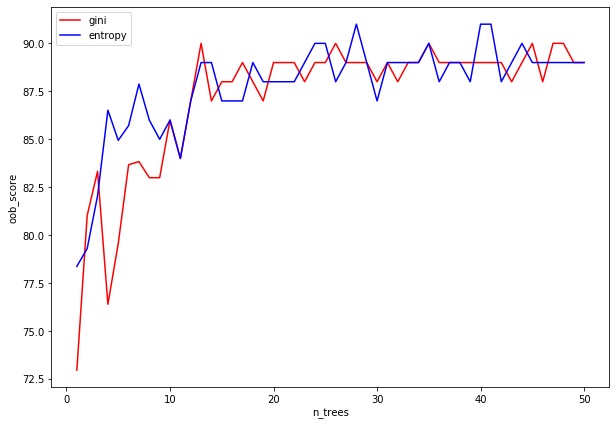

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(n_trees_arr, oob_scores, c='r')
plt.plot(n_trees_arr, oob_scores_2, c='b')
plt.legend(['gini', 'entropy'])
plt.xlabel('n_trees')
plt.ylabel('oob_score')
plt.show()

Разница в использовании в качестве критерия информативности критерия Джини и энтропийного критерия Шеннона не существенна.